In [1]:
cd C:\Users\WAHBAN\Downloads\R&D Coding exercise

C:\Users\WAHBAN\Downloads\R&D Coding exercise


In [2]:
import pyarrow.feather as feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import gurobipy as gp
from gurobipy import GRB
import pulp

The following section is to import and check the input files with a bollean operator to ensure including data with check between 90 and 110 

In [3]:
mach1 = pd.DataFrame(feather.read_feather('machine1.feather'))
mach2 = pd.DataFrame(feather.read_feather('machine2.feather'))
mask_1 = (mach1['check']>=90) & (mach1['check']<=110)
mask_2 = (mach2['check']>=90) & (mach2['check']<=110)
mach1_filtered = mach1[mask_1]
mach2_filtered = mach2[mask_2]

The input data frames is specificed for the input (x) and output(y), and split to 80:20 training and testing datasets as common data splitting practice.

In [4]:
x_mach1 = mach1_filtered[['input_1', 'input_2', 'input_3']]
y_mach1 = mach1_filtered['power']
x_mach2 = mach2_filtered[['input_1', 'input_2', 'input_3']]
y_mach2 = mach2_filtered['power']
x_mach1_train, x_mach1_test, y_mach1_train, y_mach1_test = train_test_split(x_mach1, y_mach1, test_size=0.2)
x_mach2_train, x_mach2_test, y_mach2_train, y_mach2_test = train_test_split(x_mach2, y_mach2, test_size=0.2)

In order to understand the dependency between the different variables and the power output, an initial analysis of graphs is conducted 

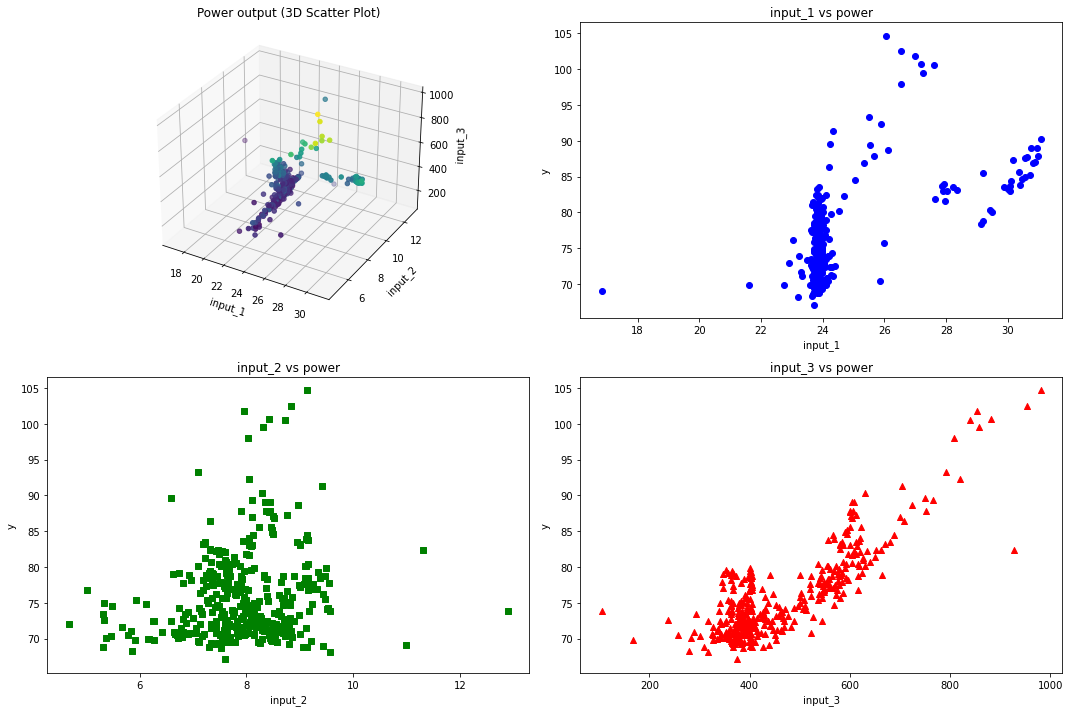

In [5]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig = plt.figure(figsize=(15, 10))

# 3D Scatter Plot
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(mach1_filtered['input_1'], mach1_filtered['input_2'], mach1_filtered['input_3'], c=y_mach1, cmap='viridis')
ax1.set_xlabel('input_1')
ax1.set_ylabel('input_2')
ax1.set_zlabel('input_3')
ax1.set_title('Power output (3D Scatter Plot)')

# input1 vs y
ax2 = fig.add_subplot(222)
ax2.scatter(mach1_filtered['input_1'], y_mach1, c='b', marker='o')
ax2.set_xlabel('input_1')
ax2.set_ylabel('y')
ax2.set_title('input_1 vs power')

# input2 vs y
ax3 = fig.add_subplot(223)
ax3.scatter(mach1_filtered['input_2'], y_mach1, c='g', marker='s')
ax3.set_xlabel('input_2')
ax3.set_ylabel('y')
ax3.set_title('input_2 vs power')

# input3 vs y
ax4 = fig.add_subplot(224)
ax4.scatter(mach1_filtered['input_3'], y_mach1, c='r', marker='^')
ax4.set_xlabel('input_3')
ax4.set_ylabel('y')
ax4.set_title('input_3 vs power')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()


The plots presented didn't provide insight into the best modelling method to be utilised for fitting input1, input2 and input3 in a model with output of the power. Hence, several modeling technquies are used to complete the analysis for Step 1. 

In [6]:
linear_reg = LinearRegression()
linear_reg.fit(x_mach1_train,y_mach1_train)
linear_reg.fit(x_mach2_train,y_mach2_train)
lin_prediction_mach1 = linear_reg.predict(x_mach1_test)
lin_prediction_mach2 = linear_reg.predict(x_mach2_test)
mae_mach1 = mean_absolute_error(y_mach1_test, lin_prediction_mach1)
mse_mach1 = mean_squared_error(y_mach1_test, lin_prediction_mach1)
mae_mach2 = mean_absolute_error(y_mach2_test, lin_prediction_mach2)
mse_mach2 = mean_squared_error( y_mach2_test, lin_prediction_mach2)
print('Mean Squared Error Machine 1:',mse_mach1)
print('Mean Absolute Error Machine 1:', mae_mach1)
print('Mean Squared Error Machine 2:',mse_mach2)
print('Mean Absolute Error Machine 2:', mae_mach2)

Mean Squared Error Machine 1: 969.7193240239478
Mean Absolute Error Machine 1: 28.894900496736092
Mean Squared Error Machine 2: 140.23988675073463
Mean Absolute Error Machine 2: 10.128366891363358


To start with the simplest modelling technique, I have introduced multivariable linear regression, eventhrough I haven't otcied a linear relationship between the dependent variable y  and the independent variables (input1, input2, input3) through the plots. As y is supposed to be equal to β₀ + β₁x₁ + β₂x₂ + ... + βₖxₖ + ε, x and y training datasets for each machine is passed through the linear regression model and tested with prediction using mean absolute error and mean squared error. From the results of the two machines, we can see that the MSE and MAE are the highest of all approaches and this indicates that multivariable linear regression model isn't suitable at all of representing the relation between y and input1, input2 and input3

Based on the results of linear regression, I am considering the application of decision tree regressor where nonlinear regression is assumed within the decision tree structure to make the predictions. 

In [7]:
tree_reg_mach1 = DecisionTreeRegressor(max_depth=5)
tree_reg_mach2 = DecisionTreeRegressor(max_depth=5)
tree_reg_mach1.fit(x_mach1_train,y_mach1_train)
tree_reg_mach2.fit(x_mach2_train,y_mach2_train)
tree_reg_mach1 = tree_reg_mach1.predict(x_mach1_test)
tree_reg_mach2 = tree_reg_mach2.predict(x_mach2_test)
mae_mach1 = mean_absolute_error(y_mach1_test, tree_reg_mach1)
mse_mach1 = mean_squared_error(y_mach1_test, tree_reg_mach1)
mae_mach2 = mean_absolute_error(y_mach2_test, tree_reg_mach2)
mse_mach2 = mean_squared_error( y_mach2_test, tree_reg_mach2)
print('Mean Squared Error Machine 1:',mse_mach1)
print('Mean Absolute Error Machine 1:', mae_mach1)
print('Mean Squared Error Machine 2:',mse_mach2)
print('Mean Absolute Error Machine 2:', mae_mach2)

Mean Squared Error Machine 1: 6.461829001780016
Mean Absolute Error Machine 1: 2.064323134480142
Mean Squared Error Machine 2: 265.9467589428642
Mean Absolute Error Machine 2: 15.712060261111112


From the results above, machine 1 provided better results due to the larger number of samples in comparison to machine 2, yet I would like to gain better model performance that can used in Step 2. That's why, random forest regression is applied to include multiple decision tree regressors aiming for better prediction results. I introduced 100 estimators as the number of decision trees with the depth given in the decision tree regressor model.

In [8]:
forest_reg_mach1 = RandomForestRegressor(n_estimators=100)
forest_reg_mach2 = RandomForestRegressor(n_estimators=100)
forest_reg_mach1.fit(x_mach1_train,y_mach1_train)
forest_reg_mach2.fit(x_mach2_train,y_mach2_train)
forest_reg_mach1 = forest_reg_mach1.predict(x_mach1_test)
forest_reg_mach2 = forest_reg_mach2.predict(x_mach2_test)
mae_mach1 = mean_absolute_error(y_mach1_test, forest_reg_mach1)
mse_mach1 = mean_squared_error(y_mach1_test, forest_reg_mach1)
mae_mach2 = mean_absolute_error(y_mach2_test, forest_reg_mach2)
mse_mach2 = mean_squared_error( y_mach2_test, forest_reg_mach2)
print('Mean Squared Error Machine 1:',mse_mach1)
print('Mean Absolute Error Machine 1:', mae_mach1)
print('Mean Squared Error Machine 2:',mse_mach2)
print('Mean Absolute Error Machine 2:', mae_mach2)

Mean Squared Error Machine 1: 5.3900408810389315
Mean Absolute Error Machine 1: 1.8664961038960948
Mean Squared Error Machine 2: 117.75209114825783
Mean Absolute Error Machine 2: 8.140122457111131


By far the results given for machine1 for MSE and MAE are imporving, but for machine 2, the results are still very far from being accurate. The smaller number of samples of machine 2 gave worse and less stable predictions.

In [ ]:
mlp_reg_mach1 = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
mlp_reg_mach2 = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
mlp_reg_mach1.fit(x_mach1_train,y_mach1_train)
mlp_reg_mach2.fit(x_mach2_train,y_mach2_train)
mlp_reg_mach1_pred = mlp_reg_mach1.predict(x_mach1_test)
mlp_reg_mach2_pred = mlp_reg_mach2.predict(x_mach2_test)
mae_mach1 = mean_absolute_error(y_mach1_test, mlp_reg_mach1_pred)
mse_mach1 = mean_squared_error(y_mach1_test, mlp_reg_mach1_pred)
mae_mach2 = mean_absolute_error(y_mach2_test, mlp_reg_mach2_pred)
mse_mach2 = mean_squared_error( y_mach2_test, mlp_reg_mach2_pred)
print('Mean Squared Error Machine 1:',mse_mach1)
print('Mean Absolute Error Machine 1:', mae_mach1)
print('Mean Squared Error Machine 2:',mse_mach2)
print('Mean Absolute Error Machine 2:', mae_mach2)

I wanted to test neural network application for fitting the model. I used a fully connected feedforward (MLP) network with a standard structure to test the dataset for machine1, I didn't include machine 2 to avoid overfitting. A standard process for scaling the input data is applied for input data for machine1; this step isn't required but recommedned for better predictions, then the input and output data are transformed into tensors. Each layer is activated using ReLu to account for potential nonlinear relation between inputs. A typical MSE loss is included for the input and output of the network with ADAM optimiser to go through 10000 epoches.

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_mach1_train)
X_test = scaler.transform(x_mach1_test)

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


input_size = 3  
model = RegressionModel(input_size)


criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_mach1_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_mach1_test.to_numpy(), dtype=torch.float32)

epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    predictions = model(X_test)
    mse = mean_squared_error(y_test, predictions.numpy())
    mae = mean_absolute_error(y_test, predictions.numpy())

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)


C:\Users\WAHBAN\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([307])) that is different to the input size (torch.Size([307, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Mean Squared Error: 31.763016
Mean Absolute Error: 4.3843584


The application resulted into worse prediction MSE than the random forest application, in addition, the 10000 required around 7 minutes for training, consequently I will not consider the application of MLP in this analysis in order to reduce the computation time and resources.  

Lastly, I would like to test polynomial linear regression as there was a a faint trend of linear relation between input3 and the power unlike input1 and input2, as polynomial regression allows linear and nonlinear between the dependent and inpdependent variables. I started the polynomial model with a second degree, with a fit transformation for the training input dataset. 

Mean Squared Error Machine 1: 5.668747706685484
Mean Absolute Error Machine 1: 1.875428464079877
R2 score Machine 1: 0.8259150510406414
Mean Squared Error Machine 2: 5.611293584146403e-22
Mean Absolute Error Machine 2: 1.9563609991261426e-11
R2 score Machine 2: 1.0
[ 0.00000000e+00  1.36857747e-01  1.39432125e+00 -1.34526897e-01
 -4.96834395e-02 -5.17332957e-02  7.00913529e-03  1.03941087e-01
 -4.70881032e-03  3.29731723e-05]
[ 0.0000000e+00  1.7395348e+00 -1.7395348e+00  7.1477800e-02
 -1.0769810e-01  2.1539620e-01 -5.1267000e-03 -1.0769810e-01
  5.1267000e-03  1.1860000e-04]


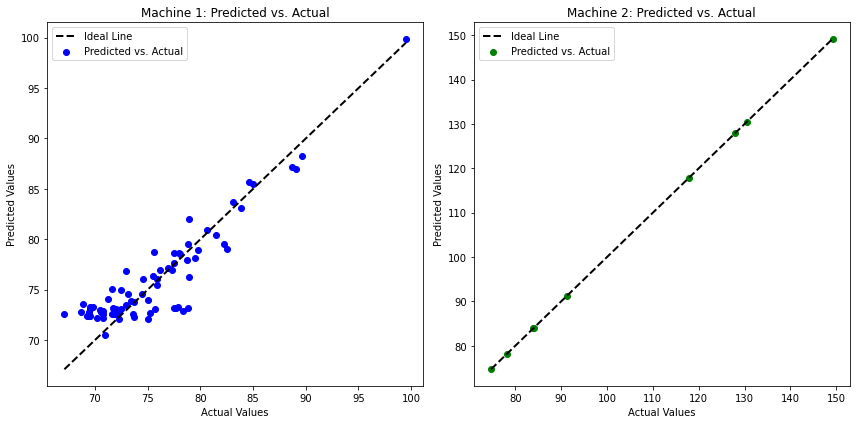

In [10]:
poly_features = PolynomialFeatures(degree=2)
x_poly_mach1 = poly_features.fit_transform(x_mach1_train)
x_poly_mach2 = poly_features.fit_transform(x_mach2_train)
x_poly_mach1_test = poly_features.fit_transform(x_mach1_test)
x_poly_mach2_test = poly_features.fit_transform(x_mach2_test)
poly_reg_mach1 = LinearRegression()
poly_reg_mach2 = LinearRegression()
poly_reg_mach1.fit(x_poly_mach1, y_mach1_train)
poly_reg_mach2.fit(x_poly_mach2, y_mach2_train)
poly_prediction_mach1 = poly_reg_mach1.predict(x_poly_mach1_test)
poly_prediction_mach2 = poly_reg_mach2.predict(x_poly_mach2_test)
mae_mach1 = mean_absolute_error(y_mach1_test, poly_prediction_mach1)
mse_mach1 = mean_squared_error(y_mach1_test, poly_prediction_mach1)
r2_score_mach1 = r2_score(y_mach1_test, poly_prediction_mach1)
mae_mach2 = mean_absolute_error(y_mach2_test,poly_prediction_mach2)
mse_mach2 = mean_squared_error( y_mach2_test,poly_prediction_mach2)
r2_score_mach2 = r2_score(y_mach2_test,poly_prediction_mach2)
coefficients_machine1 = poly_reg_mach1.coef_
coefficients_machine2 = poly_reg_mach2.coef_
print('Mean Squared Error Machine 1:',mse_mach1)
print('Mean Absolute Error Machine 1:', mae_mach1)
print('R2 score Machine 1:', r2_score_mach1)
print('Mean Squared Error Machine 2:',mse_mach2)
print('Mean Absolute Error Machine 2:', mae_mach2)
print('R2 score Machine 2:', r2_score_mach2)
print(coefficients_machine1)
print(coefficients_machine2)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_mach1_test, poly_prediction_mach1, c='blue', label='Predicted vs. Actual')
plt.plot([min(y_mach1_test), max(y_mach1_test)], [min(y_mach1_test), max(y_mach1_test)], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Machine 1: Predicted vs. Actual')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(y_mach2_test, poly_prediction_mach2, c='green', label='Predicted vs. Actual')
plt.plot([min(y_mach2_test), max(y_mach2_test)], [min(y_mach2_test), max(y_mach2_test)], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Machine 2: Predicted vs. Actual')
plt.legend()

plt.tight_layout()
plt.show()

The results of the polynomial regression are promising for machine 2 and acceptable for machine 1. Based on the above model fitting approaches, I would utilise the polynomial regression model for Step 1. As a result, the plots are provided to show the ideal linear model verses the predictions of the polynomial model. In addition, I printed the coefficients of the model in order to pass it through Step 2. 

Gurobi is applied using academic license to minimise the power consumption of the 20 machines, while maintaining the constraint of the production of 9000 GPH. I created the Gurobi model with variables of machine1  and machine2, with the upper and lower bounders specified in the exercise. Then the model optimisation is completed while printing out the solution for each machine. At first I tested the logic of the optimisation code with a basic linear model representing the two machine models. I tested this as well Pulp as an optimisation tool with a linear programming to verfiy the output of Gurobi.  

In [11]:
model = gp.Model("Factory_Optimization")

gph_type1 = model.addVars(10, lb=180, ub=600, vtype=GRB.CONTINUOUS, name="GPH_Type1")
gph_type2 = model.addVars(10, lb=300, ub=1000, vtype=GRB.CONTINUOUS, name="GPH_Type2")

power_usage = [
    25 + 6 * gph_type1[i] for i in range(10)
] + [
    25 + 6 * gph_type2[i] for i in range(10)
]
model.setObjective(gp.quicksum(power_usage), GRB.MINIMIZE)

total_gph = gph_type1.sum() + gph_type2.sum()
model.addConstr(total_gph == 9000, "Total_GPH_Constraint")

model.optimize()

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found:")
    for i in range(10):
        print(f"Machine Type 1 - Machine {i + 1}: GPH = {gph_type1[i].x}")

    for i in range(10):
        print(f"Machine Type 2 - Machine {i + 1}: GPH = {gph_type2[i].x}")

    print(f"Total Power Consumption: {model.objVal}")
else:
    print("No optimal solution found.")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-21
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0xb7852ec8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 6e+00]
  Bounds range     [2e+02, 1e+03]
  RHS range        [9e+03, 9e+03]
Presolve removed 1 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4500000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.450000000e+04
Optimal Solution Found:
Machine Type 1 - Machine 1: GPH = 180.0
Machine Type 1 - Machine 2: GPH = 180.0
Machine Type 1 - 

In [12]:
problem = pulp.LpProblem("Factory_Optimization", pulp.LpMinimize)

gph_type1 = pulp.LpVariable.dicts("GPH_Type1", range(10), lowBound=180, upBound=600, cat="Continuous")
gph_type2 = pulp.LpVariable.dicts("GPH_Type2", range(10), lowBound=300, upBound=1000, cat="Continuous")

power_usage = [
    25 + 6 * gph_type1[i] for i in range(10)
] + [
    25 + 6 * gph_type2[i] for i in range(10)
]
problem += pulp.lpSum(power_usage), "Total_Power"

total_gph = pulp.lpSum(gph_type1) + pulp.lpSum(gph_type2)
problem += total_gph == 9000, "Total_GPH_Constraint"

problem.solve()

if pulp.LpStatus[problem.status] == "Optimal":
    print("Optimal Solution Found:")
    for i in range(10):
        print(f"Machine Type 1 - Machine {i + 1}: GPH = {gph_type1[i].value()}")

    for i in range(10):
        print(f"Machine Type 2 - Machine {i + 1}: GPH = {gph_type2[i].value()}")

    print(f"Total Power Consumption: {pulp.value(problem.objective)}")
else:
    print("No optimal solution found.")

Optimal Solution Found:
Machine Type 1 - Machine 1: GPH = 180.0
Machine Type 1 - Machine 2: GPH = 600.0
Machine Type 1 - Machine 3: GPH = 180.0
Machine Type 1 - Machine 4: GPH = 600.0
Machine Type 1 - Machine 5: GPH = 600.0
Machine Type 1 - Machine 6: GPH = 600.0
Machine Type 1 - Machine 7: GPH = 600.0
Machine Type 1 - Machine 8: GPH = 180.0
Machine Type 1 - Machine 9: GPH = 180.0
Machine Type 1 - Machine 10: GPH = 180.0
Machine Type 2 - Machine 1: GPH = 300.0
Machine Type 2 - Machine 2: GPH = 300.0
Machine Type 2 - Machine 3: GPH = 1000.0
Machine Type 2 - Machine 4: GPH = 1000.0
Machine Type 2 - Machine 5: GPH = 300.0
Machine Type 2 - Machine 6: GPH = 300.0
Machine Type 2 - Machine 7: GPH = 1000.0
Machine Type 2 - Machine 8: GPH = 300.0
Machine Type 2 - Machine 9: GPH = 300.0
Machine Type 2 - Machine 10: GPH = 300.0
Total Power Consumption: 54500.0


The two approaches gave idetical results, now I will test this approach with the polynomial model resulting from Step 1. Due to the nonlinearity of the polynomial model, a nonconvex model is introduced to the Gurobi optimisation to avoid errors. Pulp optimisation results in error as it wasn't able to capture the nonlinearity in the linear programming optimisation. The coefficients of the polynomial models for each machine is used in the polynomial equation form. 

In [13]:
model = gp.Model("Factory_Optimization")
model.Params.NonConvex = 2

gph_type1 = model.addVars(10, lb=180, ub=600, vtype=GRB.CONTINUOUS, name="GPH_Type1")
gph_type2 = model.addVars(10, lb=300, ub=1000, vtype=GRB.CONTINUOUS, name="GPH_Type2")


power_usage = [
    2.56777609e+00*25 + -2.79341392e-01*6 + -9.80049358e-02* gph_type1[i] + -5.16576077e-02* 25**2 + -1.16587130e-01*6**2 + 3.75816177e-03*gph_type1[i]**2 + 2.22316593e-01*25*6 + -5.20956856e-04*25*gph_type1[i] + 4.43852692e-05*6*gph_type1[i] for i in range(10)
] + [
    1.7395348e+00*25 + -1.7395348e+00*6 + 7.1477800e-02* gph_type2[i] + -1.0769810e-01* 25**2 + 2.1539620e-01*6**2 + -5.1267000e-03*gph_type2[i]**2 + -1.0769810e-01*25*6 + 5.1267000e-03*25*gph_type2[i] + 1.1860000e-04*6*gph_type2[i] for i in range(10)
]

model.setObjective(gp.quicksum(power_usage), GRB.MINIMIZE)
# Define the constraint (total GPH equals 9,000)
total_gph = gph_type1.sum() + gph_type2.sum()
model.addConstr(total_gph == 9000, "Total_GPH_Constraint")

# Solve the optimization problem
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found:")
    for i in range(10):
        print(f"Machine Type 1 - Machine {i + 1}: GPH = {gph_type1[i].x}")

    for i in range(10):
        print(f"Machine Type 2 - Machine {i + 1}: GPH = {gph_type2[i].x}")

    print(f"Total Power Consumption: {model.objVal}")
else:
    print("No optimal solution found.")


Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x5831a813
Model has 20 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e-01]
  QObjective range [8e-03, 1e-02]
  Bounds range     [2e+02, 1e+03]
  RHS range        [9e+03, 9e+03]

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective 9019.0687810
Presolve time: 0.01s
Presolved: 12 rows, 41 columns, 61 nonzeros
Presolved model has 10 quadratic constraint(s)
Presolved model has 10 bilinear constraint(s)
Variable types: 41 continuous, 0 integer (0 binary)

Root relaxation: objective -2.997775e+04, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curren

The total power consumption is negative, signaling that the machines' models could be in correct. 